In [1]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.svm import SVR

import keras
from keras.models import Sequential
from keras.layers import Dense, Input

from sklearn.metrics import r2_score
import sklearn.metrics as metrics

Using TensorFlow backend.


# Load Data

In [2]:
data = pd.read_csv("Standard Metropolitan Areas Data - train_data.csv")
data.head()

,land_area,percent_city,percent_senior,physicians,hospital_beds,graduates,labor,income,region,crime_rate
0,1384,78.1,12.3,25627,69678,50.1,4083.9,72100,1,75.55
1,3719,43.9,9.4,13326,43292,53.9,3305.9,54542,2,56.03
2,3553,37.4,10.7,9724,33731,50.6,2066.3,33216,1,41.32
3,3916,29.9,8.8,6402,24167,52.2,1966.7,32906,2,67.38
4,2480,31.5,10.5,8502,16751,66.1,1514.5,26573,4,80.19


# Exploratory Data Analysis

## Finding correlation coefficient for each feature to every other feature.

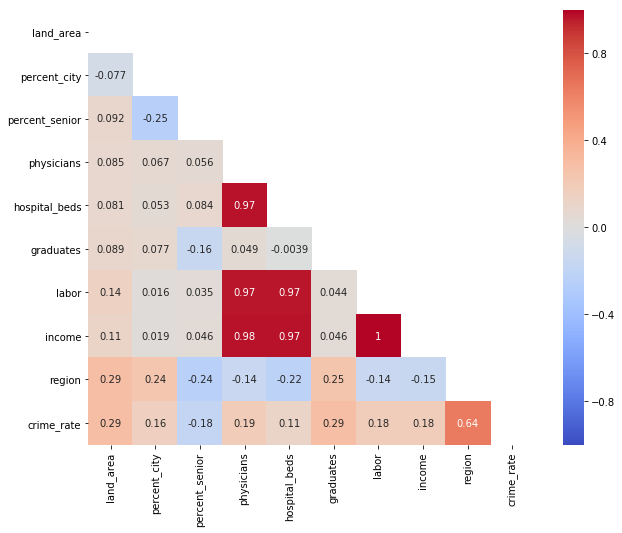

In [3]:
mask = np.zeros_like(data.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(10,8))
sns.heatmap(data.corr(),
            vmin=-1, #puts the lowest correlation number as the minimum value for the scale
            cmap='coolwarm',
            annot=True,
            mask = mask) 

In [4]:
data.shape

(99, 10)

## Checking for Null values

In [5]:
data.isnull().sum()

land_area         0
percent_city      0
percent_senior    0
physicians        0
hospital_beds     0
graduates         0
labor             0
income            0
region            0
crime_rate        0
dtype: int64

# One Hot Encoding the Regions

In [6]:
encoded_columns = pd.get_dummies(data['region'], prefix='region')
data = data.join(encoded_columns).drop('region', axis=1)
data[:5]

,land_area,percent_city,percent_senior,physicians,hospital_beds,graduates,labor,income,crime_rate,region_1,region_2,region_3,region_4
0,1384,78.1,12.3,25627,69678,50.1,4083.9,72100,75.55,1,0,0,0
1,3719,43.9,9.4,13326,43292,53.9,3305.9,54542,56.03,0,1,0,0
2,3553,37.4,10.7,9724,33731,50.6,2066.3,33216,41.32,1,0,0,0
3,3916,29.9,8.8,6402,24167,52.2,1966.7,32906,67.38,0,1,0,0
4,2480,31.5,10.5,8502,16751,66.1,1514.5,26573,80.19,0,0,0,1


# Feature Selection

- Looking at the heatmap, it can be seen that the correlation of crime_rate with percent_senior is negative. percent_senior can thus be safely removed from the training features.
- Also, physicians, hospital_beds, labor and income are highly correlated to each other which may result in redundant data. I have thus only kept income as a feature, while removing the other three.

In [7]:
x_df = data.drop(['crime_rate', 'percent_senior', 'hospital_beds', 'physicians', 'labor'],1)   #Feature Matrix
y_df = data["crime_rate"]/100

In [8]:
x_df[:5]

,land_area,percent_city,graduates,income,region_1,region_2,region_3,region_4
0,1384,78.1,50.1,72100,1,0,0,0
1,3719,43.9,53.9,54542,0,1,0,0
2,3553,37.4,50.6,33216,1,0,0,0
3,3916,29.9,52.2,32906,0,1,0,0
4,2480,31.5,66.1,26573,0,0,0,1


In [9]:
print("X Shape: {}".format(x_df.shape))
print("Y Shape: {}".format(y_df.shape))

X Shape: (99, 8)
Y Shape: (99,)


In [10]:
# x_train2 = x_train.values.reshape((-1,1))
y_df = y_df.values.reshape((-1,1))

In [11]:
print("X Shape: {}".format(x_df.shape))
print("Y Shape: {}".format(y_df.shape))

X Shape: (99, 8)
Y Shape: (99, 1)


# Scaling 

In [12]:
scaler = MinMaxScaler()
features = pd.DataFrame(scaler.fit_transform(x_df))
targets = pd.DataFrame(y_df)

features[:5]

,0,1,2,3,4,5,6,7
0,0.049071,0.747113,0.465882,1.000000,1.0,0.0,0.0,0.0
1,0.134772,0.352194,0.555294,0.753852,0.0,1.0,0.0,0.0
2,0.128679,0.277136,0.477647,0.454879,1.0,0.0,0.0,0.0
3,0.142002,0.190531,0.515294,0.450533,0.0,1.0,0.0,0.0
4,0.089298,0.209007,0.842353,0.361750,0.0,0.0,0.0,1.0


# Splitting the data into Train and Validation Sets

In [13]:
X_train, X_valid, y_train, y_valid = train_test_split(features, targets, test_size=0.1)
print("Train Data Shape: ", X_train.shape, y_train.shape)
print("Validation Data Shape: ",X_valid.shape, y_valid.shape)

Train Data Shape:  (89, 8) (89, 1)
Validation Data Shape:  (10, 8) (10, 1)


# Model Selection

## Linear Regression

In [14]:
lin_reg = LinearRegression()
linreg_model = lin_reg.fit(X_train, y_train)

print("Train Score:", linreg_model.score(X_train, y_train))
print("Validation Score:", linreg_model.score(X_valid, y_valid))

Train Score: 0.4681731049348347
Validation Score: 0.7037426049428614


## Ridge Regression

In [15]:
ridge_reg = Ridge(alpha=.5)
ridgereg_model = ridge_reg.fit(X_train, y_train)

print("Train Score:", ridgereg_model.score(X_train, y_train))
print("Validation Score:", ridgereg_model.score(X_valid, y_valid))

Train Score: 0.46416208771519857
Validation Score: 0.6858148815143135


## Support Vector Regression

In [16]:
svr = SVR(C=0.47, epsilon=0.1)
svr_model = svr.fit(X_train, y_train.values.ravel())

print("Train Score:", svr_model.score(X_train, y_train))
print("Validation Score:", svr_model.score(X_valid, y_valid))

Train Score: 0.5919602450842106
Validation Score: 0.8088371611374476


## Deep Learning

In [17]:
model = Sequential()

model.add(Dense(9, activation='sigmoid', input_dim=X_train.shape[1]))
model.add(Dense(5, activation='sigmoid'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 9)                 81        
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 50        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 137
Trainable params: 137
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=False)

In [19]:
print("Train Score: ",metrics.r2_score(y_train, model.predict(X_train).reshape(-1,)))
print("Validation Score: ", metrics.r2_score(y_valid, model.predict(X_valid).reshape(-1,)))

Train Score:  0.47184757477731787
Validation Score:  0.7204156151293679


# Conclusion

I observed that the SVR has performed the best on the given dataset and with the following hyper parameters. So I'll next use that model to perform predictions on the testing set.

# Predictions on Test Set

In [43]:
test_data = pd.read_csv("Standard Metropolitan Areas Data - model_prediction.csv")
test_data.head()

,land_area,percent_city,percent_senior,physicians,hospital_beds,graduates,labor,income,region,crime_rate
0,3650,34.6,11.1,2358,6224,62.9,539.3,7792,4,NaN
1,4883,72.4,7.3,873,2236,64.9,185.2,2353,4,NaN
2,1435,13.4,11.7,342,1076,44.7,156.8,2165,1,NaN
3,2042,24.5,16.5,4071,10039,51.9,681.7,10166,3,NaN
4,1630,41.9,10.7,724,4395,50.0,198.0,2445,3,NaN


In [44]:
test_data.shape

(42, 10)

In [45]:
one_hot_regions_test = pd.get_dummies(test_data['region'], prefix='region')
one_hot_regions_test[:5]

,region_1,region_2,region_3,region_4
0,0,0,0,1
1,0,0,0,1
2,1,0,0,0
3,0,0,1,0
4,0,0,1,0


In [46]:
test_features = test_data.drop(['crime_rate', 'percent_senior', 'hospital_beds', 'physicians', 'labor', 'region'], axis=1)

In [47]:
'''
transforming the test data based on the fitted training data
'''

test_features = pd.concat([test_features, one_hot_regions_test], axis=1)
test_features_scaled = scaler.transform(test_features)
test_features = pd.DataFrame(test_features_scaled)

test_features[:5]

,0,1,2,3,4,5,6,7
0,0.132240,0.244804,0.767059,0.098456,0.0,0.0,0.0,1.0
1,0.177494,0.681293,0.814118,0.022206,0.0,0.0,0.0,1.0
2,0.050943,0.000000,0.338824,0.019571,1.0,0.0,0.0,0.0
3,0.073222,0.128176,0.508235,0.131738,0.0,0.0,1.0,0.0
4,0.058100,0.329099,0.463529,0.023496,0.0,0.0,1.0,0.0


In [48]:
predictions = svr_model.predict(test_features)*100
crime_rate = pd.DataFrame(predictions.reshape(-1,1))

In [49]:
test_data['crime_rate'] = crime_rate

In [50]:
test_data

,land_area,percent_city,percent_senior,physicians,hospital_beds,graduates,labor,income,region,crime_rate
0,3650,34.6,11.1,2358,6224,62.9,539.3,7792,4,69.723490
1,4883,72.4,7.3,873,2236,64.9,185.2,2353,4,68.415921
2,1435,13.4,11.7,342,1076,44.7,156.8,2165,1,32.893557
3,2042,24.5,16.5,4071,10039,51.9,681.7,10166,3,62.218355
4,1630,41.9,10.7,724,4395,50.0,198.0,2445,3,58.196566
5,7874,44.4,6.9,398,1365,65.2,174.2,2410,4,71.025739
6,2527,78.7,8.4,1760,7664,46.5,391.1,5582,3,52.019298
7,1300,47.6,6.8,2794,4989,69.0,610.8,9215,4,65.336699
8,1700,18.8,8.0,739,3381,45.9,120.4,1616,3,58.737156
9,476,8.9,10.9,787,2778,60.1,218.4,3603,1,40.469572


## Save to a CSV File

In [51]:
test_data.to_csv('Predictions.csv', index=False)